# Droplets

This *jupyter* notebook carries out the analyses in the upcoming journal article focusing on analyzing gravitationally unbound, coherent structures with significant velocity gradients.  The notebook is edited to work with data and *Python* scripts in the [Github repo](https://github.com/hopehhchen/Droplets).

## 0. Abstract and Outlines

The project looks for coherent cores with significant velocity gradients in the L1688 region in Ophiuchus and the B18 region in Taurus, out of the four nearby star forming regions covered by the *GBT Ammonia Survey* (GAS) Data Release 1 ([Friesen and Pineda et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract)).  One goal of the project is to update numbers for physical properties of (potentially) rotational motions within these structures.  The relation between the velocity gradient and the size was first examined using observations of ammonia molecular line emission by [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract).  With an improved physical resolution of ~4000 AU (the FWHM beam size at the distance of Ophiuchus and Taurus), we hope to provide more reliable and relevant numbers for simulations and analytical models, especially ones concerning with disk formation inside star forming cores.

Subsequent analyses included in this project discover that the structures are possibly gravitationally unbound, despite subsonic velocity dispersions and relatively high column densities.  The behavior is unexpected in the final stages of monolithic star formation driven by gravity.  Due to their small sizes and the seeming unboundness, we term these structures "droplets," to distinguish them from "cores," which are often used to indicate bound and star forming, sub-parsec structures.  The project aims at providing a guess to how the "droplets" are formed and what role they could play in the star formation process.

This notebook is organized as follows. In ***I. Identification of Structures***, we go through how we identify these structures and how we define the boundaries.  In ***II. Physical Properties of Droplets***, we derive the basic physical properties of the "droplets," based on the property maps from ammonia line fitting to the GAS DR1 data.  In ***III. Kinematics and Dynamics***, we look for possible explanations to the formation of "droplets" and the role they play in star formation.  In particular, we look into the spatial distribution of ram pressure within and around the "droplets," to see whether the droplets could be pressure-bound.  In all sections of this notebook, we also provide the codes to generate tables and plots that eventually appear in the corresponding parts of the article.

Further discussions are included in the article hosted on Authorea.  **This notebook, though filled with definitions essential for users to understand the analyses, is *not* meant to be complete or continuous as the journal article itself.**  Please look in the article for details.

***CAUTION: This is work in progress.***

[*The square brackets in this notebook host the technical explanations of following code cells.  They should be treated as code comments.*]

#### Authors
* **Hope Chen** (leading and corresponding, at <hhchen@cfa.harvard.edu>; Harvard-Smithsonian Center for Astrophysics)
* Jaime Pineda (Max-Planck-Institut für Extraterrestrische Physik)
* Alyssa Goodman (Harvard-Smithsonian Center for Astrophysics)
* Andreas Burkert (University Observatory Munich)

#### Code Dependencies
* `numpy`
* `scipy`
* `astropy`
* `FITS_tools`
* `matplotlib`
* `pandas`

In [18]:
%matplotlib inline
import sys
import os

#
import numpy as np

#
from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
import astropy.constants as c
import FITS_tools as fits_tools

#
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#
import pandas as pd

## 
import styles

##
import astropy.modeling as modeling

## 0.1 Data and Targets

The GAS DR1 inlcudes observations of the ammonia hyperfine line emission made with the *Green Bank Telescope* (GBT).  By fitting Guassian profiles to the ammonia hyperfine lines, [Friesen and Pineda et al. (2017)](https://ui.adsabs.harvard.edu/#abs/2017ApJ...843...63F/abstract) derive the property maps of four nearby star forming regions: B18 in Taurus, L1688 in Ophiuchus, NGC1333 in Perseus, and Orion A North.  These physical properties include the NH$_3$ velocity centroid (in the LSR frame; $V_\text{LSR}$), the NH$_3$ velocity dispersion ($\sigma_V$), the NH$_3$ column density (N$_{\text{NH}_3}$), the excitation temperature of NH$_3$ hyperfine lines (T$_\text{ex}$), and the kinetic temperature (T$_\text{kin}$).  Besides property maps included as part of the GAS DR1, we also derive the peak main beam temperature from the trimmed and baseline subtracted data cubes from observations of NH$_3$ (1, 1) hyperfine lines.  We look for coherent structures using these physical properties in the B18 region and the L1688 region, where their proximity (at the distances of ~135 and ~137.3 pc, respectively; [Schlafly et al., 2014](https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...29S/abstract); [Ortiz-León et al., 2017](https://ui.adsabs.harvard.edu/#abs/2017ApJ...834..141O/abstract)) grants us the highest physical resolution (the GBT FWHM beamsize of 32" at 23 GHz corresponds to ~4300 AU).

[*The Python dictionary `distances` stores the distances that are used throughout this paper, in the formats of `astropy.units`.*]

In [38]:
distances = {'L1688': 137.3*u.pc, 'B18': 135.*u.pc}

The GAS data are supplemented by the column density and dust temprature maps derived using *Herschel* observations of dust continuum emission.  The *Herschel* observations were made as part of the *Herschel Gould Belt Survey* (GBS; [André et al., 2010](https://ui.adsabs.harvard.edu/#abs/2010A&A...518L.102A/abstract)), and the data are from the *Herschel* Science Archive.  The FWHM beamsize of SPIRE 500 µm is 36", which matches well with the GBT beamsize.

The full GAS DR1 dataset is hosted on [Dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project), which includes the original data cubes from GBT observations of various molecular lines.  The peak main beam temperature maps were not included in the set of property maps in the GAS DR1, but were instead derived from the trimmed and baseline subtracted data cubes.  Due to the github policy for large data files, the  [Droplets github repo](https://github.com/hopehhchen/Droplets) includes only the data maps that are needed in the analyses, but not the data cubes from which the property maps were derived.

[*The datasets are read and stored in `dict_data`.  The maps of error in each phsyical property were produced for the GAS DR1 alongside the property maps, and are stored in `dict_data` with a prefix "`e`".  The property maps in the GAS DR1 are flagged by the detection level and the goodness of the fit.  In the array directly read in from files in [this github repo](https://github.com/hopehhchen/Droplets) and in the [GAS DR1 dataverse](https://dataverse.harvard.edu/dataverse/GAS_Project), the flagged pixels within the observed areas have values of 0.  In the following code cell, we remove the flags by converting them to NaN values, for the ease of future calculation.  This is not done for the maps of the peak main beam temperature, which is derived from the data cubes that include the full observed areas.*]

In [39]:
# data folder (within the current directory)
direcData = os.getcwd()+'/data/'
## lists of property maps to be read in
list_propertiesGAS = ['Vlsr', 'Sigma', 'N_NH3', 'Tex', 'Tkin']
list_propertiesHerschel = ['colden', 'temp']


# Read the data.
dict_data = {'L1688': {}, 'B18': {}}
for reg in ['L1688', 'B18']:
    
    # GAS DR1 Property Maps
    for prop in list_propertiesGAS:
        ## data
        data = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_'+prop+'_DR1_rebase3_flag.fits')[0].data
        data[data == 0.] = np.nan ## Remove the flags
        dict_data[reg][prop] = data
        
        ## error maps
        data = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_e'+prop+'_DR1_rebase3_flag.fits')[0].data
        data[data == 0.] = np.nan ## Remove the flags
        dict_data[reg]['e'+prop] = data
    ## header
    dict_data[reg]['header_GAS'] = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_Vlsr_DR1_rebase3_flag.fits')[0].header
    
    # GAS DR1 Peak Main Beam Temperature
    dict_data[reg]['Tpeak'] = fits.open(direcData+'GAS_DR1/'+reg+'/'+reg+'_Tpeak_DR1_rebase3_trim.fits')[0].data
    
    # Herschel
    for prop in list_propertiesHerschel:
        dict_data[reg][prop] = fits.open(direcData+'Herschel/'+reg+'/'+reg+'_'+prop+'_masked.fits')[0].data
    ## header
    dict_data[reg]['header_Herschel'] = fits.open(direcData+'Herschel/'+reg+'/'+reg+'_colden_masked.fits')[0].header

Several properties that are immediately derivable from the property maps include the total velocity dispersion ($\sigma_\text{tot}$) and its thermal and non-thermal components ($\sigma_\text{T}$ and $\sigma_\text{NT}$, respectively).  These can be derived from the NH$_3$ linewidth ($\sigma_{\text{NH}_3}$) and the kinetic temperature of the gas ($T_\text{kin}$), assuming that different species of molecules are at a thermal equilibrium.  The equation used here is: $$\sigma_\text{tot}^2 = \sigma_{\text{NH}_3}^2 - \frac{k_B T_\text{kin}}{m_{\text{NH}_3}} + \frac{k_B T_\text{kin}}{\mu m_\text{H}} \text{,}$$ where $m_{\text{NH}_3}$ is the molecular weight of NH$_3$ and $\mu m_\text{H}$ is the average particle weight in the atomic mass unit (a.m.u.).  Throughout this paper, we use $\mu = 2.37$ based on the results presented by [Kauffmann et al. (2008)](https://ui.adsabs.harvard.edu/#abs/2008A&A...487..993K/abstract), and $m_{\text{NH}_3} = 17.031\ \text{a.m.u.}$ according to the [IUPAC value](https://pubchem.ncbi.nlm.nih.gov/compound/ammonia#section=Top).

[*The derived properties: $\sigma_\text{tot}$, $\sigma_\text{T}$, and $\sigma_\text{NT}$ are stored in the same dictionary: `dict_data`.  The following code cell might generate a warning regarding invalid value encoutered in sqrt, which by default would simply produce a NaN value at the pixel(s).  The warning message is due to the unlikely event where the observed NH$_3$ linewidth is narrower than the thermal linewidth of the NH$_3$ molecules expected at the observed kinetic temperature.  This happens only at ~0.01% of the sky areas observed in the L1688 and B18 regions combined.*]

In [11]:
for reg in ['L1688', 'B18']:
    
    # NH3 linewidth and kinetic temperature from GAS DR1
    sigmaNH3 = dict_data[reg]['Sigma']
    Tkin = dict_data[reg]['Tkin']
    
    
    # derived properties
    ## thermal and non-thermal components
    sigmaNT = np.sqrt((sigmaNH3*u.km/u.s)**2. - c.k_B*Tkin*u.K/(17.031*u.u)).to(u.km/u.s).value
    sigmaT = np.sqrt(c.k_B*Tkin*u.K/(2.37*u.u)).to(u.km/u.s).value
    ## total velocity dispersion
    sigmaTot = np.sqrt((sigmaNT*u.km/u.s)**2.+(sigmaT*u.km/u.s)**2.).to(u.km/u.s).value
    
    
    # store the derived maps
    dict_data[reg]['SigmaNT'] = sigmaNT
    dict_data[reg]['SigmaT'] = sigmaT
    dict_data[reg]['SigmaTot'] = sigmaTot

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


For easier comparison between the GAS DR1 data and the *Herschel* maps, we project the *Herschel* maps to the GAS DR1 grid.  As mentioned above, the GBT has a FWHM beamsize at 23 GHz (32") similar to the FWHM beamsize of *Herschel* 500 µm (36").  Thus, we can safely assume that the regridding does not introduce a significant biase.

[*The regridding is done using the *Python* package [`FITS_tools`](http://fits-tools.readthedocs.io/en/latest/fits_tools.html).  The newly projected images replace the original images in `dict_data`.*]

In [4]:
# Regrid the Herschel maps.
for reg in ['L1688', 'B18']:
    
    for prop in list_propertiesHerschel:
        
        # Regrid using hcongrid.
        image = dict_data[reg][prop].copy()
        header1 = dict_data[reg]['header_Herschel'] ## original projection
        header2 = dict_data[reg]['header_GAS'] ## projection to interpolate into
        
        dict_data[reg][prop] = fits_tools.hcongrid.hcongrid(image, header1, header2)

## I. Identification of Structures

We look for coherent structures ([Goodman et al., 1993](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract)) in the L1688 region in Ophiuchus and the B18 region in Taurus.  [Goodman et al. (1993)](https://ui.adsabs.harvard.edu/#abs/1993ApJ...406..528G/abstract) proposed that these coherent structures represent the smallest scale in the self-similar process of star formation in turbulent clouds, within which the dominant gravity drives the final stage of star formation.  The coherent structures are defined by a boundary of sharp transition in linewidth, from supersonic linewidths outside to subsonic linewidths inside the coherent structures.  Thus, our selection and definition of target structures are based on comparison between the thermal ($\sigma_\text{T}$) and non-thermal ($\sigma_\text{NT}$) components of velocity dispersion.  We also look for coherent structures that also show a local peak in column density.

In [135]:
!pwd

/Users/hopechen/Documents/projects/git_projects/Droplets/Droplets


In [136]:
os.getcwd()

'/Users/hopechen/Documents/projects/git_projects/Droplets/Droplets'

In [77]:
direcMasks = os.getcwd()+'/data/masks/'
dict_masks = {'L1688': {}, 'B18': {}}

for reg in ['L1688', 'B18']:
    if reg == 'L1688':
        nCores = 12
    elif reg == 'B18':
        nCores = 6
        
    for i in range(1, nCores+1):
        dict_masks[reg][i] = fits.open(direcMasks+reg+'/'+reg+'_'+str(i)+'.fits')[0].data.astype(bool)
        
    if reg == 'L1688':
        dict_masks[reg]['extra'] = fits.open(direcMasks+reg+'/'+reg+'_extra.fits')[0].data.astype(bool)

In [134]:
def centroidMask(mask):
    '''
    The function used to calculate the centroid of the boolean mask.
    
    Input
    ------
    mask: a 2D-array, either of type boolean, or any type that can be converted to the boolean.
    
    Output
    ------
    xcent, ycent: (x, y) [axis-1 and axis-0]
    '''
    
    # Create the coordinate grids.
    mask = mask.astype(bool)
    xgrid, ygrid = np.meshgrid(np.arange(mask.shape[1], dtype = float),
                               np.arange(mask.shape[0], dtype = float))
    
    # Calculate the centroid based on the boolean mask.
    xcent = np.average(xgrid[mask],
                       weights = mask[mask].astype(float))
    ycent = np.average(ygrid[mask],
                       weights = mask[mask].astype(float))
    
    
    
    return xcent, ycent


def fitGradient(mask, Vlsr, eVlsr):
    '''
    The function used to fit a 1st-degree 2D polynomial to the Vlsr field.
    
    Input
    ------
    mask:
    
    Vlsr:
    
    Output
    ------
    gradfit: an astropy.modeling.model object
    
    fitter: an astropy.modeling.fitting object
    
    Vlsr_predicted:
    '''
    
    # Create the coordinate grid; shift acoording to the centroid; read Vlsr and eVlsr.
    mask = mask.astype(bool)
    xcent, ycent = centroidMask(mask)
    xgrid, ygrid = np.meshgrid(np.arange(mask.shape[1], dtype = float),
                               np.arange(mask.shape[0], dtype = float))
    xgrid -= xcent
    ygrid -= ycent
    ## Read Vlsr and eVlsr.
    zgrid = Vlsr
    wgrid = 1./eVlsr**2. ## Weight the fits by the reciprocal of the uncertainty squared.
    
    # Fit using `astropy.modeling`.
    gradfit = modeling.polynomial.Polynomial2D(1)
    fitter = modeling.fitting.LevMarLSQFitter()
    gradfit = fitter(gradfit,
                     xgrid[mask&np.isfinite(Vlsr)],
                     ygrid[mask&np.isfinite(Vlsr)],
                     Vlsr[mask&np.isfinite(Vlsr)],
                     weights = wgrid[mask&np.isfinite(Vlsr)])
    
    # Generate a map of predicted Vlsr.
    Vlsr_predicted = gradfit(xgrid, ygrid)
    
    
    
    return gradfit, fitter, Vlsr_predicted

def convertAngle(angle):
    '''
    The function that converts the numpy angles to PA [E of N] and remove redundancies.
    
    Input
    ------
    angle: in degrees.
    '''
    
    # Rotate by 90 degrees counter-clockwise.
    angle = angle - 90.
    
    # Remove degeneracy around the 180 degree mark.
    if angle <= 0.:
        angle = angle + 180.
    
    # Convert angles in the SE quadrant to positive values.
    if angle <= 0.:
        angle = angle + 180.
    
    
    
    return angle


def readGradient(gradfit, fitter, header, reg):
    '''
    The function that converts the `astropy.modeling` object to physical values.
    
    Input
    ------
    gradfit:
    
    Output
    ------
    GradMag: The gradient magnitude, in km/s/pc. [`astropy.units` object]
    
    eGradMag: The uncertainty in the gradient magnitude measurement.
    
    GradPA: The position angle of the fitted velocity graidnet, in degrees. [E of N]
    
    eGradPA: The uncertainty in the position angle measurement.
    '''
    
    # Calculate the pixel scale (the corresponding physical scale at the distance of the region).
    pixscale = np.radians(abs(header['CDELT1']))*distances[reg]
    
    # Convert the gradients to physical units (km/s/pc).
    gradx, grady = gradfit.parameters[1]*u.km/u.s/pixscale, gradfit.parameters[2]*u.km/u.s/pixscale
    
    # Calculate the magnitude and the PA based on the converted x- and y-components.
    GradMag = (np.sqrt(gradx**2.+grady**2.)).to(u.km/u.s/u.pc).value  ## in km/s/pc
    GradPA = convertAngle(np.degrees(np.arctan2(grady.value, gradx.value)))  ## in degrees
    
    # Estimate the uncertainty from the covariant matrix.
    ## the raw parameters
    x, y = gradfit.parameters[1], gradfit.parameters[2]
    ## uncertainties in x and y
    sigx, sigy = fitter.fit_info['param_cov'][2, 2], fitter.fit_info['param_cov'][3, 3]
    ## propagation to GradMag
    eGradMag = np.sqrt((sigx*x/np.sqrt(x**2.+y**2.))**2.+(sigy*y/np.sqrt(x**2.+y**2.))**2.)
    eGradMag *= u.km/u.s/pixscale  ## Convert to physical units.
    ## propagation to GradPA
    eGradPA = np.sqrt((sigx*(1./(1.+(y/x)**2.))*(-y/x**2.))**2.+\
                      (sigy*(1./(1.+(y/x)**2.))*(1./x))**2.)
    eGradPA = np.degrees(eGradPA)  ## Convert to degrees.
    
    
    
    
    return GradMag, eGradMag, GradPA, eGradPA

In [131]:
from sympy import *
x, y, z = symbols('x y z')

In [ ]:
sig1 = np.sqrt((fit_p.fit_info['param_cov'])[1, 1])
    sig2 = np.sqrt((fit_p.fit_info['param_cov'])[2, 2])
    x1 = p.parameters[1]
    x2 = p.parameters[2]
    fx1x2 = np.sqrt(x1**2.+x2**2.)
    V_grad_mag = fx1x2
    V_grad_mag_Err = np.sqrt((x1/fx1x2)**2.*sig1**2.+(x2/fx1x2)**2.*sig2**2.) # error

In [125]:
reg = 'B18'
iCore = 6

mask, Vlsr, eVlsr = dict_masks[reg][iCore], dict_data[reg]['Vlsr'], dict_data[reg]['eVlsr']

test = fitGradient(mask, Vlsr, eVlsr)

result = readGradient(test[0], dict_data[reg]['header_GAS'], reg)

print result, result[1]-180.

(6.055371340880194, 77.056677558799095) -102.943322441


In [126]:
fitter = test[2]

In [128]:
fitter.fit_info['param_cov']

array([[  8.06437029e-06,  -4.46582920e-07,  -1.78829024e-06],
       [ -4.46582920e-07,   6.23031395e-07,  -4.44156404e-07],
       [ -1.78829024e-06,  -4.44156404e-07,   1.69990479e-06]])

In [119]:
grad._param_metrics

defaultdict(dict,
            {'c0_0': {u'orig_unit': None,
              u'raw_unit': None,
              u'shape': (),
              u'slice': slice(0, 1, None)},
             'c0_1': {u'orig_unit': None,
              u'raw_unit': None,
              u'shape': (),
              u'slice': slice(2, 3, None)},
             'c1_0': {u'orig_unit': None,
              u'raw_unit': None,
              u'shape': (),
              u'slice': slice(1, 2, None)}})

In [84]:
result[1]

45.897566238435246

In [60]:
a = 359.*u.deg
b = 2.*u.deg

In [62]:
(a+b)/2.

<Quantity 180.5 deg>

In [36]:
gradfit.parameters

array([ 3.38177047,  0.00948525, -0.0098688 ])

In [37]:
gradfit.param_names

(u'c0_0', u'c1_0', u'c0_1')

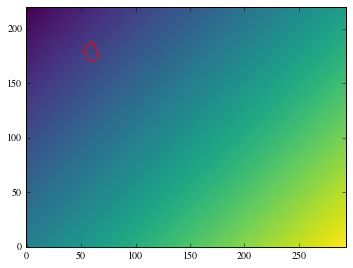

In [34]:
plt.imshow(test[1])

plt.contour(mask,
            levels = [.5],
            colors = 'r')

In [16]:
test = 3.

test -= 1.

print test

2.0


In [15]:
reg = 'L1688'
iCore = 2
centroidMask(dict_masks[reg][iCore])

(59.025974025974023, 178.98701298701297)

In [ ]:
fig, axes = plt.subplots(figsize = (14., 14.),
                         nrows = 3,
                         ncols = 2)
target = dict_masks

ax